In [1]:
# Helper Functions
def to_binary(n, N):
    """
    Get binary representation of input n

    :param n: Integer of which to get binary representation
    :param N: Length of bitstring
    :return: str
    """
    return bin(n).replace('0b', '').zfill(N)


def get_w_hat_t_helper(row_idx, col_idx, N):
    """
    Helper function to get entry (t, col_idx) of W-H matrix

    :param row_idx: Row index of W-H matrix to find
    :param col_idx: Column index of W-H matrix to find
    :param N: Order of W-H matrix
    :return: int
    """
    row_bin = to_binary(row_idx, N)
    col_bin = to_binary(col_idx, N)

    row_list = [int(row_bit) for row_bit in list(row_bin[::-1])]
    col_list = [int(col_bit) for col_bit in list(col_bin[::-1])]

    result = 0
    for row_bit, col_bit in zip(row_list, col_list):
        result += row_bit * col_bit

    result = int((1 + ((-1) ** result)) / 2)
#     return (2 * result) - 1
    return result

def get_x_vector(N, K):
    """
    Return x from given order of WH matrix and K

    :param N: Order of WH matrix
    :param K: Number of ones
    :return: numpy.ndarray
    """
    x = np.zeros(N)
    random_pos = np.random.choice(
        np.arange(0, N), K, replace=False
    )
    x[random_pos] = 1
    return x

def get_w_hat_t(t_idx: int) -> list:
    """
    Get t-th row of W-H matrix of order _N

    :param t_idx: Index of row in W-H matrix
    :return: list
    """
    row = []
    for i in range(N):
        row.append(get_w_hat_t_helper(t_idx, i, N))

    return row

100%|██████████| 64/64 [00:00<00:00, 147.22it/s]


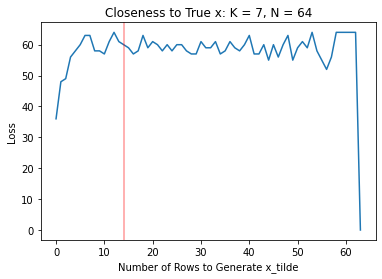

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(0)

K = 7
N = 64

x = np.zeros(N)
random_pos = np.random.choice(np.arange(0, N), K, replace=False)
x[random_pos] = 1

# Get Walsh-Hadamard
wh = [get_w_hat_t(i) for i in range(N)]

def x_sample_rows(n_rows):
    W_hat = np.empty((0, N))
    loss = []

    y = []
    np.random.seed(0)
    row_pos = np.random.choice(np.arange(0, N), n_rows, replace=False)

    for row_idx in row_pos:
        W_hat = np.vstack([W_hat, wh[row_idx]]) # stack of rows
        W_hat_inv = np.linalg.pinv(W_hat)
        curr_y = x.dot(wh[row_idx])
        y.append(curr_y)
        x_tilde = np.round(W_hat_inv.dot(y), 2)
        loss.append((x_tilde == x).all())
    
    return x_tilde

diff = []

for i in tqdm(range(1, N + 1)):
    diff.append(N - np.count_nonzero(
        np.isclose(x_sample_rows(i) - x, np.zeros(N), atol=0.01)
    ))

plt.plot(diff)
plt.xlabel('Number of Rows to Generate x_tilde')
plt.ylabel('Loss')
plt.axvline(int(K * np.log2(N) / np.log2(K)), c='r', alpha=0.4)
plt.title(f'Closeness to True x: K = {K}, N = {N}')
plt.show()